In [1]:
import pandas as pd
import numpy as np 
import sqlite3
import matplotlib.pyplot as plt
import re

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,7)

In [9]:
conn = sqlite3.connect('../../data/HH_vacancy.db')
df = pd.read_sql('select * from WOWEN',con=conn)
conn.close()


df['Tags'] = df['Tags'].str.findall(r'([A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$)))')

df['Salary'] = df['Salary'].str.replace('\xa0','').str.extract('(\d+)').astype('float')
df['Salary'] = df['Salary'].apply(lambda x: x*80 if x < 10000 else x)
df['Exp'] = df['Exp'].str.findall('\d').apply(lambda x: min(x) if x!=[] else 0).astype(int)
df ['Stack'] = df['Description'].str.findall('([A-Z][A-z]{2,})').apply(lambda x: list(set(x)))


In [10]:
df['Stack'].explode().value_counts().iloc[:20]

Linux         206
DevOps        179
Docker        175
Kubernetes    173
Ansible       157
Python        134
Prometheus    134
Grafana       118
PostgreSQL    116
ELK            92
Jenkins        90
Kafka          86
Gitlab         85
GitLab         78
Zabbix         76
Bash           76
Terraform      68
Redis          61
Nginx          60
Git            58
Name: Stack, dtype: int64

array([[<AxesSubplot:title={'center':'0'}, xlabel='Stack'>,
        <AxesSubplot:title={'center':'1'}, xlabel='Stack'>],
       [<AxesSubplot:title={'center':'3'}, xlabel='Stack'>,
        <AxesSubplot:title={'center':'6'}, xlabel='Stack'>]], dtype=object)

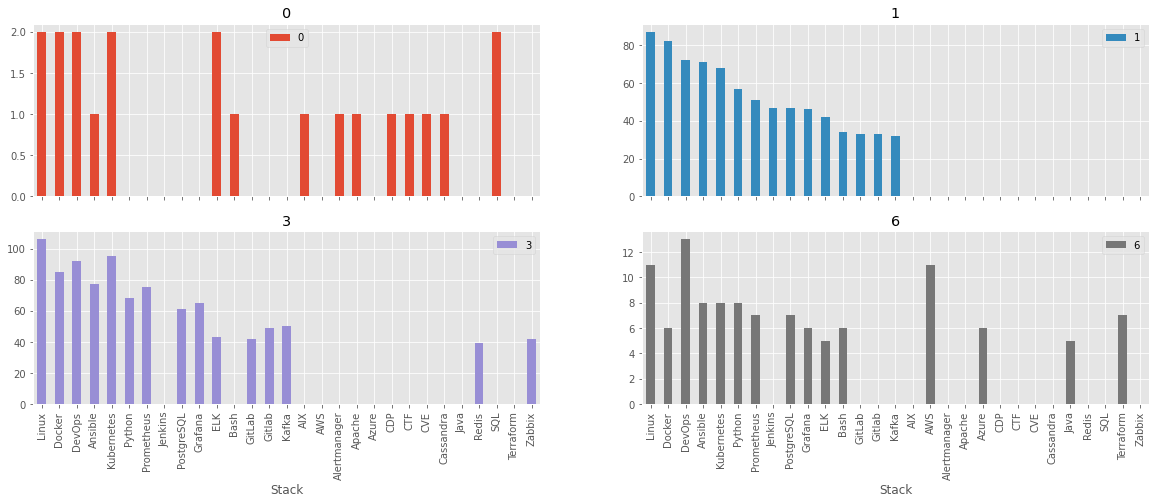

In [12]:
df[['Exp','Stack']].explode('Stack').groupby('Exp')['Stack'].value_counts()\
    .groupby(level=0).nlargest(15).reset_index(0,drop=True).unstack(0).sort_values(by=1,ascending=False).plot.bar(subplots=True,layout=(2,2))

<AxesSubplot:title={'center':'Salary'}, xlabel='Exp'>

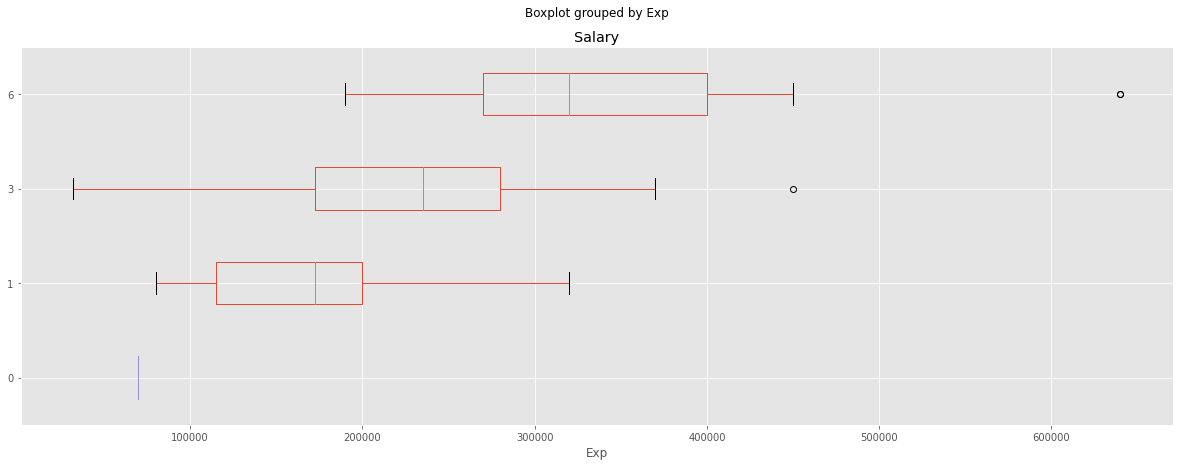

In [13]:
df.boxplot('Salary',by='Exp',vert=False)

In [14]:
df['is_russia']=df['Description'].apply(lambda x: len(re.findall('[А-я]+',x)) / (len(re.findall('[A-z]+',x)))).clip(0,1)

In [22]:
stack_salary_impact = df.query('is_russia!=0 & Exp<3')[['Stack','Salary']].explode('Stack').groupby('Stack')['Salary'].agg(['mean','count']).where(lambda x: x['count']>5).dropna()['mean'].div(df.query('is_russia!=0  & Exp<3')['Salary'].median()).sub(1).sort_values(ascending=False)

<AxesSubplot:title={'center':'Impact of stack with median wage 200k'}, ylabel='Stack'>

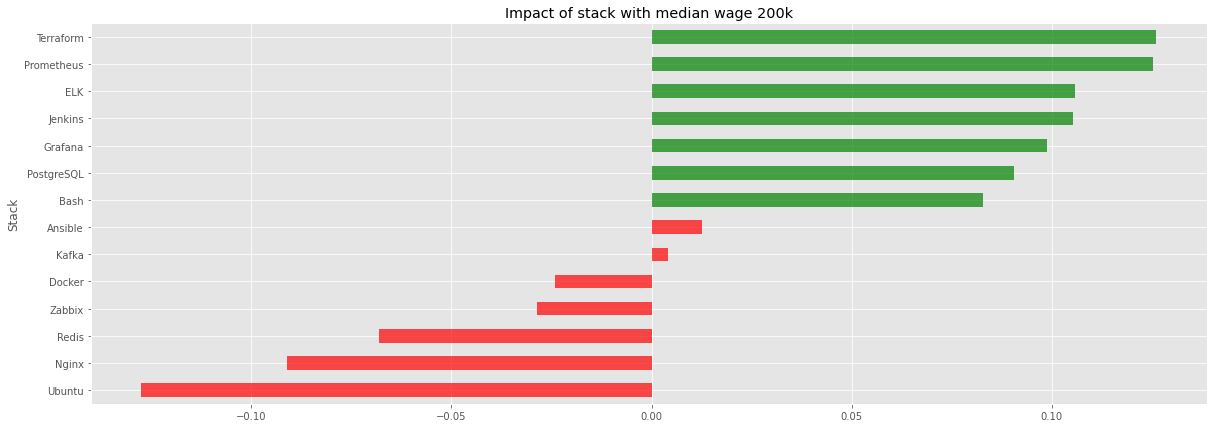

In [25]:
stack_salary_impact.head(7).append(stack_salary_impact.tail(7)).iloc[::-1].plot.barh(color=['r']*7+['g']*7,title=f'Impact of stack with median wage {df.query("is_russia!=0").Salary.median()/1000:.0f}k',alpha=0.7)

In [17]:
df[df.Description.str.contains('[J|j]un') | df.Name.str.contains('[J|j]un')]

,Name,Company,Salary,Exp,Type,Description,Tags,url,date,Query,Stack,is_russia
14,Разработчик инструментов DevOps,Сбер. IT,NaN,1,"Полная занятость, полный день",SberTech приглашает в свою дружную команду раз...,"[Linux, Bash, Git, Ansible, Jenkins, Java, Pyt...",https://hh.ru/vacancy/54239257,2022-04-22,,"[Infrastructure, Java, Teamcity, DevOps, Iac, ...",1.0
21,Devops в отдел технической поддержки,ФГБУ Федеральный научно- технический центр гео...,150000.0,3,"Полная занятость, полный день",Обязанности: Администрирование Windows Server...,"[Linux, Postgre, SQL, Bash, Git, Python]",https://hh.ru/vacancy/54995083,2022-04-22,,"[Asterisk, Unix, Infrastructure, TCP, Kubernet...",1.0
29,"DevOps инженер trainee, junior, middle, lead",Альфа-Банк,NaN,1,"Полная занятость, полный день",Ищем Devops инженера Junior и Middle уровней. ...,"[Python, Postgre, SQL, Bash, Linux, Mongo, DB]",https://hh.ru/vacancy/54759005,2022-04-22,,"[Mesos, Alertmanager, SLES, Spring, Kafka, Son...",1.0
154,Junior DevOps / DevSecOps Engineer (в компанию...,Нек. орг. Фонд Сколково,NaN,1,"Полная занятость, полный день",Компания с 2011 года предоставляет услуги по з...,"[Linux, Bash, Git]",https://hh.ru/vacancy/54827104,2022-04-22,,"[Ansible, Python, CTF, DevOps, Terraform, Linu...",1.0
161,Junior DevOps,ООО Управляющая компания Мой Гектар,NaN,1,"Полная занятость, удаленная работа",Видео о нас: https://youtu.be/UAOje6ycew4 В 20...,"[Git, Docker, My, SQL, Linux, Gitlabci, Kubern...",https://hh.ru/vacancy/51364421,2022-04-22,,"[Ansible, Grafana, PostgreSQL, Docker, Terrafo...",1.0
176,Top-notch DevOps/SRE engineer,Diabolocom,400000.0,6,"Полная занятость, полный день",IMPORTANT NOTES: Please only apply to this job...,"[Docker, Ansible, Terraform, AWS, Kubernetes, ...",https://hh.ru/vacancy/54573112,2022-04-22,,"[Milan, Passionate, France, CRM, Virtualizatio...",0.0
199,Инженер по внедрению\Junior Devops,Бюджетные и Финансовые Технологии,NaN,1,"Полная занятость, полный день",БФТ-Холдинг (входит в группу компаний «Ростеле...,"[Linux, Postgre, SQL]",https://hh.ru/vacancy/54928287,2022-04-22,,"[Postgresql, MvGzPmdlw, MySQL, Confluence, Atl...",1.0
202,Инженер (Junior Devops),ГКУ Инфогород,NaN,1,"Полная занятость, полный день",Департамент информационных технологий внедряет...,"[Linux, V, Mware, Zabbix, Kubernetes]",https://hh.ru/vacancy/46175057,2022-04-25,,"[VMware, Tanzu, Docker, Windows\Linux, Linux, ...",1.0
238,Junior DevOps в команду инженерных практик,АО Национальная система платежных карт,NaN,1,"Полная занятость, полный день",КОМАНДА:Команда инженеров по автоматизации про...,"[Linux, Git, Python, Docker, Ansible, Jenkins]",https://hh.ru/vacancy/54002792,2022-05-13,DevOps,"[Spring, Bamboo, Kafka, ELK, Confluence, DevOp...",1.0
256,Devops engineer,ПАО «Газпром нефть»,NaN,1,"Полная занятость, полный день",Мы – команда «Газпромнефть – Цифровые решения»...,"[Git, Linux, Bash, Python, Postgre, SQ, Ldevop...",https://hh.ru/vacancy/55378040,2022-05-13,DevOps,"[TCP, Agile, Kubernetes, MySQL, Confluence, Op...",1.0


In [18]:
top_30_stack = df['Stack'].explode().value_counts().iloc[:30].index

In [19]:
data = df[['Salary','Description','Exp']].dropna()

In [20]:
for i in top_30_stack:
    data[f'has_{i}'] = data['Description'].str.contains(i)

<AxesSubplot:>

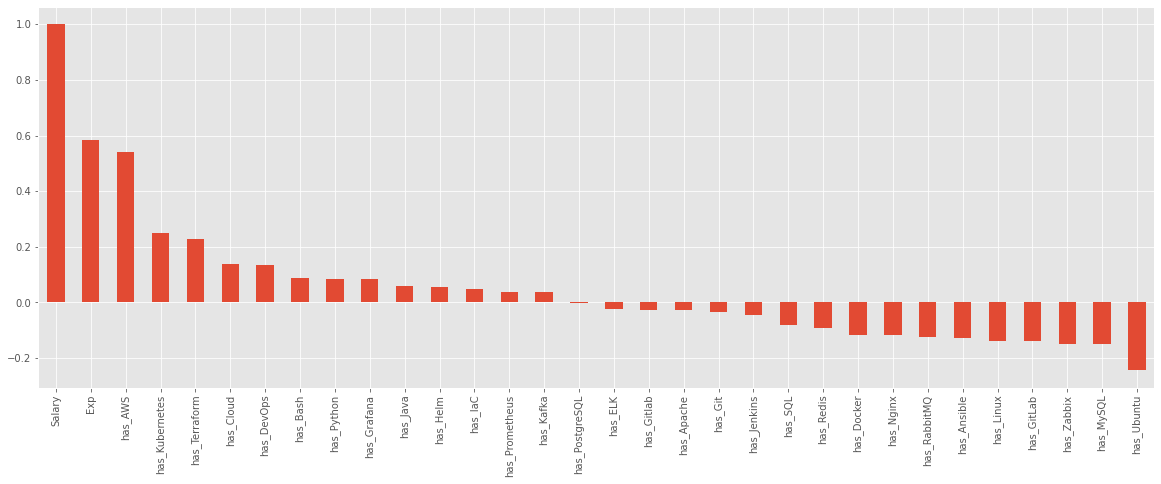

In [21]:
data.corr()['Salary'].sort_values(ascending=False).plot.bar()